In [1]:
import os
import time
import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import multi_gpu_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
filename='SH2.csv'
dataframe=pd.read_csv(filename)
dataframe.head()

,Close,open,high,low,hand,volume,F,SKDJ(D),KDJ(D),KDJ(K),...,VOL5,VOL40,VOL89,vol5_40_bias,vol5_89_bias,price_5_bias,price_13_bias,price_34_bias,MA5_13_bias,MA34_144_bias
0,537.87,550.26,550.26,537.38,48247800,223117000.0,-3.137100,5.730000,1.478671,0.936012,...,69445240.0,107154232.5,216223033.7,-35.191323,-67.882589,-3.697271,-7.609095,-13.734046,-4.062007,-9.350545
1,542.42,535.23,542.74,530.79,55619200,252574000.0,0.845929,5.690394,1.687469,2.105065,...,69590040.0,103458467.5,215186340.4,-32.736255,-67.660568,-1.835095,-5.928480,-12.385263,-4.169907,-9.848756
2,558.76,541.94,558.94,539.76,110591300,451488000.0,3.012426,8.960170,2.780079,4.965300,...,75525840.0,99839812.5,213543276.4,-24.352983,-64.632068,1.549892,-2.507677,-9.212491,-3.995641,-10.251229
3,536.37,559.03,561.36,536.12,138637100,597185000.0,-4.007087,12.971799,3.193653,4.020801,...,87065820.0,98177905.0,213085471.9,-11.318315,-59.140424,-1.789278,-5.708490,-12.264196,-3.990615,-10.712704
4,539.17,533.33,540.04,527.91,69620700,287150000.0,0.522028,16.677408,3.495391,4.098867,...,84543220.0,96596832.5,211752736.0,-12.478269,-60.074556,-0.690344,-4.533469,-11.227193,-3.869840,-11.198075


In [3]:
dataframe.describe()

,Close,open,high,low,hand,volume,F,SKDJ(D),KDJ(D),KDJ(K),...,VOL5,VOL40,VOL89,vol5_40_bias,vol5_89_bias,price_5_bias,price_13_bias,price_34_bias,MA5_13_bias,MA34_144_bias
count,5085.000000,5085.000000,5085.000000,5085.000000,5.085000e+03,5.085000e+03,5085.000000,5085.000000,5085.000000,5085.000000,...,5.085000e+03,5.085000e+03,5.085000e+03,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000
mean,2125.322369,2123.707383,2144.315908,2101.430570,7.644093e+09,8.245835e+10,0.048802,55.546826,53.615944,53.635091,...,7.637441e+09,7.564394e+09,7.474867e+09,3.174944,6.500467,0.073771,0.227540,0.633512,0.137223,1.847031
std,962.255556,961.173591,973.935208,946.158155,1.072977e+10,1.359567e+11,1.724738,26.390609,31.200738,31.531443,...,1.057249e+10,1.023390e+10,9.983400e+09,34.970721,47.857882,1.908122,3.512869,6.195506,2.331709,11.621942
min,516.460000,515.000000,521.000000,512.830000,3.296580e+07,1.533740e+08,-9.911012,5.690394,1.324777,0.870137,...,4.085276e+07,9.002581e+07,1.020116e+08,-67.990670,-78.097467,-16.731048,-20.460929,-23.809051,-15.183956,-27.876691
25%,1386.653000,1386.845000,1399.766000,1374.791000,8.261204e+08,6.700151e+09,-0.731346,30.737186,25.025629,24.772555,...,8.477971e+08,9.040770e+08,8.770052e+08,-20.307255,-25.070751,-0.906319,-1.713840,-3.175127,-1.135731,-5.460602
50%,2004.172000,2000.695000,2018.156000,1986.071000,3.851885e+09,2.515581e+10,0.068270,57.658840,53.955661,53.800698,...,3.906086e+09,3.710719e+09,3.834322e+09,-2.937846,-4.075348,0.113630,0.249322,0.427222,0.170644,0.518902
75%,2732.990000,2725.140000,2755.367000,2688.529000,1.054925e+10,1.080000e+11,0.867151,80.344721,83.910917,84.085329,...,1.065227e+10,1.026392e+10,1.052617e+10,19.148000,27.487853,1.104193,2.172641,4.069147,1.461965,8.279590
max,6092.057000,6057.428000,6124.044000,6040.713000,8.571328e+10,1.310000e+12,9.857043,98.209151,99.285970,99.682565,...,7.287152e+10,6.267494e+10,5.829744e+10,268.314304,408.894765,11.051826,17.687736,29.209538,11.243283,35.276619


In [4]:
dataframe.dtypes

Close            float64
open             float64
high             float64
low              float64
hand               int64
volume           float64
F                float64
SKDJ(D)          float64
KDJ(D)           float64
KDJ(K)           float64
SKDJ(RSV)        float64
SKDJ(K)          float64
MA5              float64
MA13             float64
MA21             float64
MA34             float64
MA55             float64
MA89             float64
MA144            float64
MA233            float64
VOL5             float64
VOL40            float64
VOL89            float64
vol5_40_bias     float64
vol5_89_bias     float64
price_5_bias     float64
price_13_bias    float64
price_34_bias    float64
MA5_13_bias      float64
MA34_144_bias    float64
dtype: object

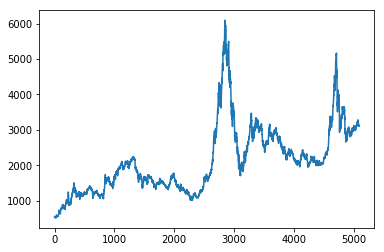

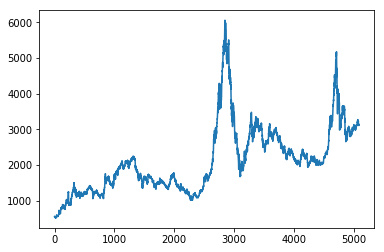

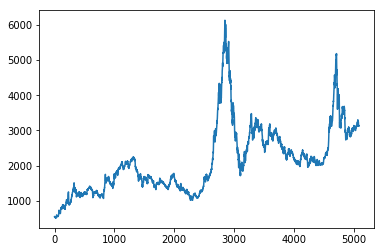

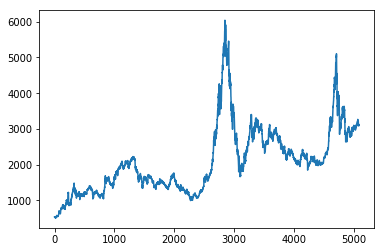

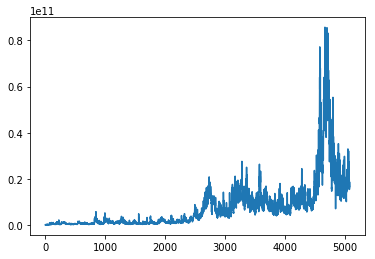

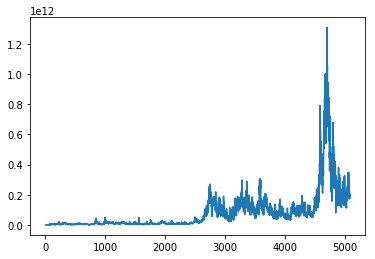

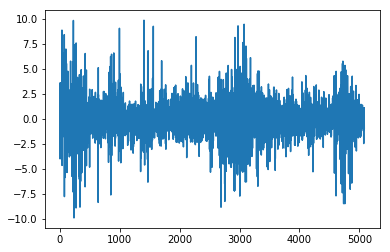

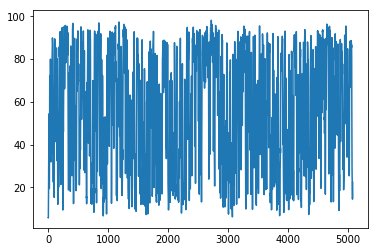

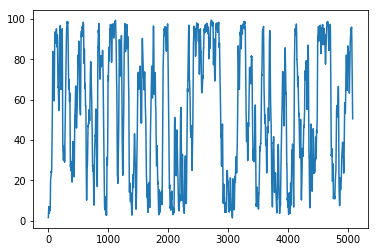

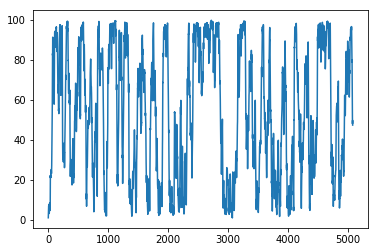

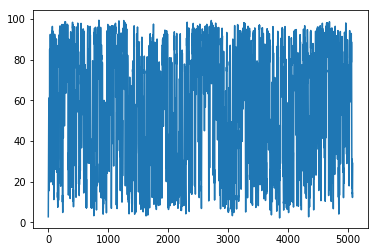

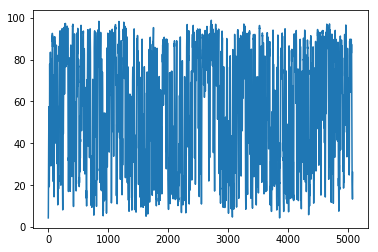

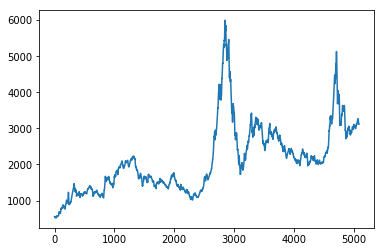

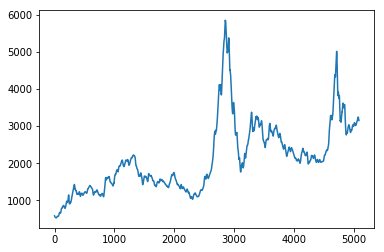

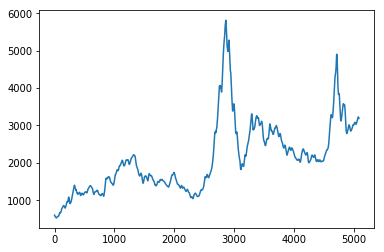

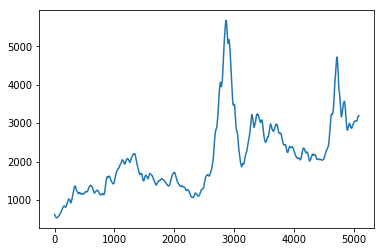

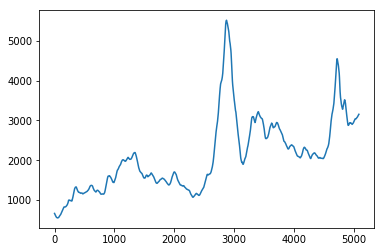

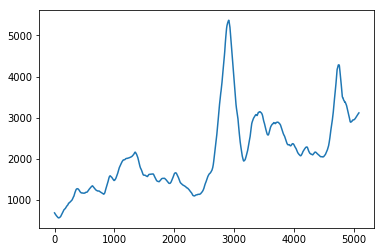

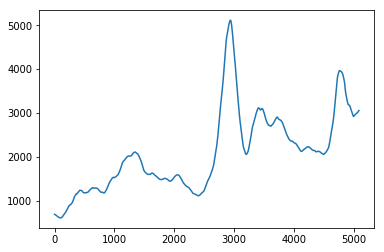

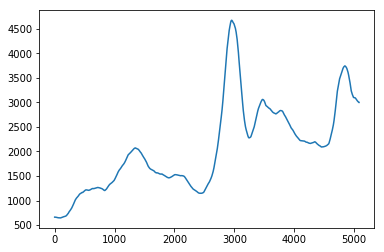

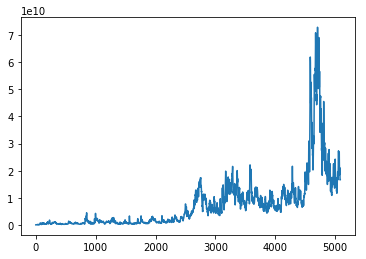

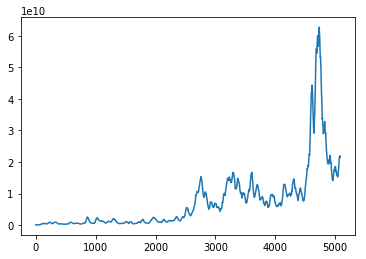

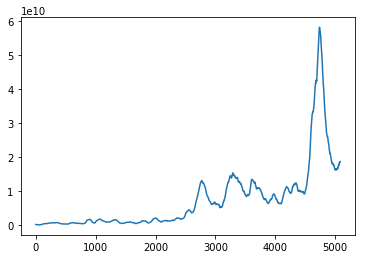

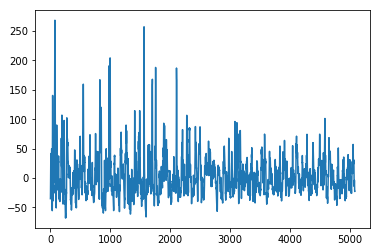

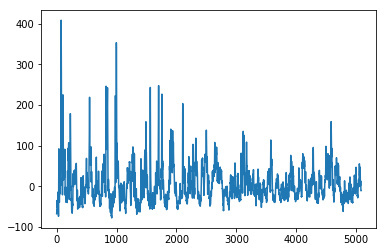

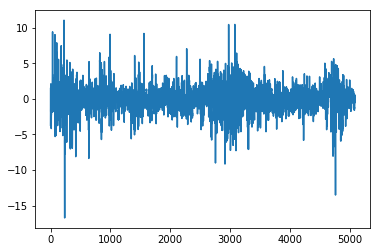

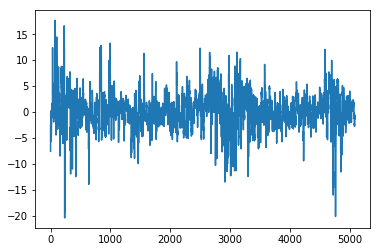

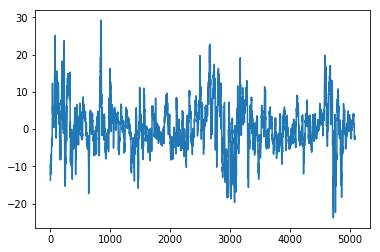

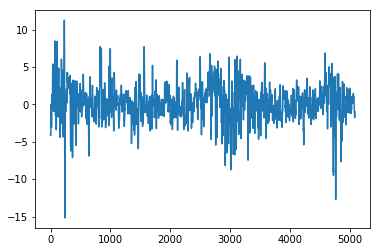

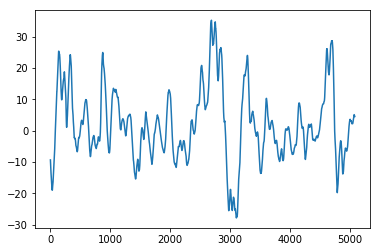

In [5]:
for column in dataframe.columns:
    plt.plot(dataframe[column])
    plt.show()

In [6]:
data=dataframe.values
data=data.astype('float32')
data[:2]

array([[ 5.3787000e+02,  5.5026001e+02,  5.5026001e+02,  5.3738000e+02,
         4.8247800e+07,  2.2311699e+08, -3.1370995e+00,  5.7300000e+00,
         1.4786707e+00,  9.3601215e-01,  2.8034844e+00,  4.3837423e+00,
         5.5852002e+02,  5.8216766e+02,  5.9999426e+02,  6.2350208e+02,
         6.5993164e+02,  6.8694110e+02,  6.8781665e+02,  6.6234521e+02,
         6.9445240e+07,  1.0715423e+08,  2.1622304e+08, -3.5191322e+01,
        -6.7882591e+01, -3.6972713e+00, -7.6090951e+00, -1.3734046e+01,
        -4.0620070e+00, -9.3505449e+00],
       [ 5.4241998e+02,  5.3522998e+02,  5.4273999e+02,  5.3078998e+02,
         5.5619200e+07,  2.5257400e+08,  8.4592932e-01,  5.6903944e+00,
         1.6874689e+00,  2.1050651e+00,  9.0631390e+00,  6.7234406e+00,
         5.5256000e+02,  5.7660382e+02,  5.9558954e+02,  6.1909674e+02,
         6.5702289e+02,  6.8488269e+02,  6.8673126e+02,  6.6238257e+02,
         6.9590040e+07,  1.0345846e+08,  2.1518634e+08, -3.2736256e+01,
        -6.7660568e+01,

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
norm_data = scaler.fit_transform(data)
norm_data[:2]

array([[3.8399473e-03, 6.3618347e-03, 5.2221641e-03, 4.4411197e-03,
        1.7836070e-04, 5.3245152e-05, 3.4266967e-01, 4.2808428e-04,
        1.5709624e-03, 6.6666584e-04, 5.6906752e-03, 0.0000000e+00,
        7.0418045e-03, 1.0496408e-02, 1.3919495e-02, 1.7404094e-02,
        2.2739612e-02, 2.5402732e-02, 1.8153533e-02, 3.8926154e-03,
        3.9258850e-04, 2.7368276e-04, 1.9625505e-03, 9.7528584e-02,
        2.0975426e-02, 4.6912992e-01, 3.3688819e-01, 1.9002777e-01,
        4.2085177e-01, 2.9335195e-01],
       [4.6559945e-03, 3.6500245e-03, 3.8800314e-03, 3.2489747e-03,
        2.6439448e-04, 7.5734046e-05, 5.4415780e-01, 0.0000000e+00,
        3.7024003e-03, 1.2497698e-02, 7.0124090e-02, 2.4781618e-02,
        5.9532225e-03, 9.4517916e-03, 1.3086975e-02, 1.6547471e-02,
        2.2155054e-02, 2.4974428e-02, 1.7912760e-02, 3.9018989e-03,
        3.9457664e-04, 2.1463074e-04, 1.9447365e-03, 1.0482871e-01,
        2.1431342e-02, 5.3615594e-01, 3.8094255e-01, 2.1546759e-01,
        4

In [8]:
scalerY = MinMaxScaler(feature_range=(0, 1))
norm_Y = scalerY.fit_transform(data[:,0].reshape(-1,1))
norm_Y[:2]

array([[0.00383995],
       [0.00465599]], dtype=float32)

In [9]:
split_ratio=0.9
train_size = int(len(norm_data) * split_ratio)
test_size = len(norm_data) - train_size
train, test = norm_data[0:train_size,:], norm_data[train_size:,:]
print(len(norm_data),len(train), len(test))

5085 4576 509


In [10]:
def create_dataset(dataset, window_size=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-window_size-1):
        dataX.append(dataset[i:(i+window_size), :])
        dataY.append(dataset[i + window_size, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
window_size = 10
features=norm_data.shape[1]
trainX, trainY = create_dataset(train, window_size)
testX, testY = create_dataset(test, window_size)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(4565, 10, 30) (4565,) (498, 10, 30) (498,)


In [12]:
model = Sequential()

model.add(LSTM(input_shape=(window_size, features),units=32,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=128,return_sequences=False))
model.add(Dropout(0.4))

model.add(Dense(units=256))
model.add(Dropout(0.6))

model.add(Dense(units=1))
model.add(Activation("sigmoid"))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 32)            8064      
_________________________________________________________________
dropout (Dropout)            (None, 10, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
__________

In [14]:
start = time.time()

model.compile(loss="mse", optimizer="adam", metrics=['mae', 'acc'])

print("> Compilation Time : ", time.time() - start)

> Compilation Time :  0.029947996139526367


In [15]:
tensorboard = TensorBoard(log_dir = os.getcwd() +'\\'+"logs\\Multu-feature-prediction-{}".format(int(time.time())))
model.fit(x=trainX, y=trainY, batch_size=256, epochs=50, validation_split=0.10, verbose=1, callbacks=[tensorboard])

Train on 4108 samples, validate on 457 samples
Epoch 1/50
4108/4108 [==============================] - 2s 408us/step - loss: 0.0396 - mean_absolute_error: 0.1556 - acc: 2.4343e-04 - val_loss: 0.0049 - val_mean_absolute_error: 0.0637 - val_acc: 0.0000e+00
Epoch 2/50
4108/4108 [==============================] - 1s 147us/step - loss: 0.0067 - mean_absolute_error: 0.0623 - acc: 2.4343e-04 - val_loss: 0.0039 - val_mean_absolute_error: 0.0449 - val_acc: 0.0000e+00
Epoch 3/50
4108/4108 [==============================] - 1s 148us/step - loss: 0.0033 - mean_absolute_error: 0.0435 - acc: 2.4343e-04 - val_loss: 5.5774e-04 - val_mean_absolute_error: 0.0172 - val_acc: 0.0000e+00
Epoch 4/50
4108/4108 [==============================] - 1s 145us/step - loss: 0.0024 - mean_absolute_error: 0.0380 - acc: 2.4343e-04 - val_loss: 5.6672e-04 - val_mean_absolute_error: 0.0172 - val_acc: 0.0000e+00
Epoch 5/50
4108/4108 [==============================] - 1s 159us/step - loss: 0.0021 - mean_absolute_error: 0.035

Epoch 39/50
4108/4108 [==============================] - 1s 159us/step - loss: 6.7854e-04 - mean_absolute_error: 0.0201 - acc: 2.4343e-04 - val_loss: 2.5261e-04 - val_mean_absolute_error: 0.0144 - val_acc: 0.0000e+00
Epoch 40/50
4108/4108 [==============================] - 1s 146us/step - loss: 6.4931e-04 - mean_absolute_error: 0.0195 - acc: 2.4343e-04 - val_loss: 8.4288e-05 - val_mean_absolute_error: 0.0075 - val_acc: 0.0000e+00
Epoch 41/50
4108/4108 [==============================] - 1s 149us/step - loss: 6.4745e-04 - mean_absolute_error: 0.0195 - acc: 2.4343e-04 - val_loss: 4.9459e-05 - val_mean_absolute_error: 0.0056 - val_acc: 0.0000e+00
Epoch 42/50
4108/4108 [==============================] - 1s 150us/step - loss: 6.7039e-04 - mean_absolute_error: 0.0197 - acc: 2.4343e-04 - val_loss: 1.4292e-04 - val_mean_absolute_error: 0.0102 - val_acc: 0.0000e+00
Epoch 43/50
4108/4108 [==============================] - 1s 148us/step - loss: 6.3028e-04 - mean_absolute_error: 0.0193 - acc: 2.434

In [16]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [17]:
trainPredictPrice=scalerY.inverse_transform(trainPredict)
testPredictPrice=scalerY.inverse_transform(testPredict)

In [18]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.06 RMSE


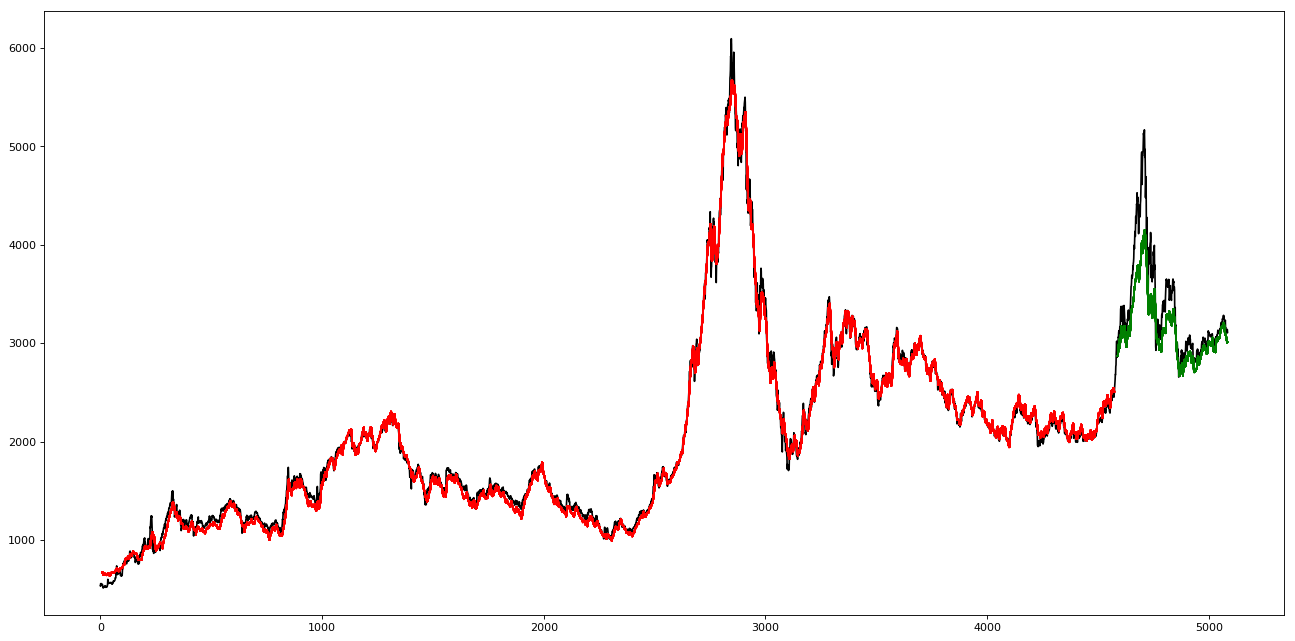

In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(norm_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredictPrice
# shift test predictions for plotting
testPredictPlot = np.empty_like(norm_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2)+1:len(norm_data)-1, :] = testPredictPrice
figure(figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
# plot baseline and predictions
plt.plot(data[:,0], label='original', color='black')
plt.plot(trainPredictPlot, label='train prediction', color='red')
plt.plot(testPredictPlot, label='test prediction', color='green')
plt.show()

In [20]:
next_day_X=norm_data[-window_size:,:].reshape(1,window_size,features)
next_day_prediction= model.predict(next_day_X)
next_day_prediction_price=scalerY.inverse_transform(next_day_prediction)
next_day_prediction_price[0][0]

3020.3677